In [73]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import numpy.random
import seaborn as sns
from scipy import signal
import emcee
import corner
import time
import matplotlib.mlab as mlab

In [74]:
def t_shift(x, n, tau, N, dt):
    # time shift the array x to be x(t-n*tau), and have the right dimension
    
    x_shifted = x[int(n*tau/dt): int(N + n*tau/dt)]

    return x_shifted

def n_X_tdi(n1, n1p, n2p, n3, dur, tau, dt, fs, N):
    # noise that shows up in TDI-X
    
    n1_2t  = t_shift(n1, 2, tau, N, dt)
    n1p_2t = t_shift(n1p, 2, tau, N, dt)
    n2p_3t = t_shift(n2p, 3, tau, N, dt)
    n3_3t  = t_shift(n3, 3, tau, N, dt)
    n1     = n1[0:N]
    n1p    = n1p[0:N]
    n2p    = n2p[0:N]
    n3     = n3[0:N]
    
    return (n1 - n1_2t) + (n1p - n1p_2t) + (n2p - n2p_3t) + (n3 - n3_3t)
    

def get_X_data(c_inj, dur, tau, dt, fs, N):

    c1_inj, c1p_inj, c2p_FS_inj, c3_FS_inj, d_inj, e_inj = c_inj
    t         = np.arange(0, dur+5*tau, dt)
    mu        = 0.
    sigma_phi = (10e-9)*((fs/2)**0.5)
    phi1    = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
    phi1p   = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
    phi2p   = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
    phi3    = np.random.normal(mu, sigma_phi, int((dur+5*tau)/dt))
    
    phi1_2t  = t_shift(phi1, 2, tau, N, dt)
    phi1_4t  = t_shift(phi1, 4, tau, N, dt)
    phi1p_2t = t_shift(phi1p, 2, tau, N, dt)
    phi1p_4t = t_shift(phi1p, 4, tau, N, dt)
    phi2p_t  = t_shift(phi2p, 1, tau, N, dt)
    phi2p_3t = t_shift(phi2p, 3, tau, N, dt)
    phi3_t   = t_shift(phi3, 1, tau, N, dt)
    phi3_3t  = t_shift(phi3, 3, tau, N, dt)
    
    phi1  = phi1[0:N]
    phi1p = phi1p[0:N]
    phi2p = phi2p[0:N]
    phi3  = phi3[0:N]

    sigma_n = (10e-12)*((fs/2)**0.5)
    n1  = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
    n1p = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
    n2p = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))
    n3  = np.random.normal(mu, sigma_n, int((dur+5*tau)/dt))

    n_shot = n_X_tdi(n1, n1p, n2p, n3, dur, tau, dt, fs, N)

    # Simulating data
    f1 = -phi1 + phi1_2t
    f2 = phi1p - phi1p_2t
    f3 = -phi1_2t + phi1_4t
    f4 = phi1p_2t - phi1p_4t
    f5 = -phi2p_t + phi2p_3t
    f6 = phi3_t - phi3_3t

    X = c1_inj*f1 + c1p_inj*f2 + c2p_FS_inj*f3 + c3_FS_inj*f4 + d_inj*f5 + e_inj*f6 + n_shot 

    return X,f1,f2,f3,f4,f5,f6

def get_X_model(c1,c1p,c2p_FS,c3_FS,d,e,DWS_vec):

    # DWS signal combinations
    f1,f2,f3,f4,f5,f6 = DWS_vec

    # Model
    X = c1*f1 + c1p*f2 + c2p_FS*f3 + c3_FS*f4 + d*f5 + e*f6

    return X


In [75]:
def log_likelihood(theta, y, yerr):  ## CHECK ME
    c1, c1p, c2p_FS, c3_FS, d, e, sigma2 = theta
    model = get_X_model(c1,c1p,c2p_FS,c3_FS,d,e, DWS_vec)
    
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    c1, c1p, c2p_FS, c3_FS, d, e, sigma2 = theta
    u = 5e-3 # TTL Range
    
    if -u < c1 < u and -u < c1p < u and -u < c2p_FS < u and -u < c3_FS < u and -u < d < u and -u < e < u and 0 <= sigma2:
        return 0.0
    return -np.inf

def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)


In [96]:
# Signal parameters

dur = 600. # 10 mins
#dur = 24*3600 # 1 day
tau = 2.5e9/3e8  # time delay along arms
fs  = 10
dt  = 1./fs   # time resolution
N   = int(dur/dt)

In [97]:
# Create TDI-X data and recover using linear regression

# Injection 
c1_inj     = 1.1e-3
c1p_inj    = 2.3e-4
c2p_FS_inj = 5e-4
c3_FS_inj  = -3.1e-4
d_inj      = -2.6e-3
e_inj      = 7e-4
c_inj = [c1_inj, c1p_inj, c2p_FS_inj, c3_FS_inj, d_inj, e_inj]

X_data,f1_data,f2_data,f3_data,f4_data,f5_data,f6_data = get_X_data(c_inj, dur, tau, dt, fs, N)
DWS_vec = [f1_data,f2_data,f3_data,f4_data,f5_data,f6_data] # DWS signal combinations 'data'

X_err = np.zeros(len(X_data)) # hack

In [105]:
## Run MCMC simulation

time0 = time.time()

# Initializing sampler
ndim, nwalkers = 7, 25
num_threads = 3
num_iter = 500000

u = 5e-3
#init0 = np.random.uniform(-u, u)
#init  = [init0, init0, init0, init0, init0, init0, 0]
init = np.zeros(7)

pos_c1     = init[0] + 1e-7 * np.random.randn(nwalkers)
pos_c1p    = init[1] + 1e-7 * np.random.randn(nwalkers)
pos_c2p_FS = init[2] + 1e-7 * np.random.randn(nwalkers)
pos_c3_FS  = init[3] + 1e-7 * np.random.randn(nwalkers)
pos_d      = init[4] + 1e-7 * np.random.randn(nwalkers)
pos_e      = init[5] + 1e-7 * np.random.randn(nwalkers)
pos_sigma  = init[6] + np.abs(1e-2 * np.random.randn(nwalkers))
pos = np.c_[pos_c1, pos_c1p, pos_c2p_FS, pos_c3_FS, pos_d, pos_e, pos_sigma]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(X_data, X_err))
sampler.reset()
sampler.run_mcmc(pos, num_iter, progress=True);

print('time taken = ', (time.time()-time0)/60, ' mins')


100%|██████████| 500000/500000 [18:28<00:00, 450.92it/s]

time taken =  18.493736251195273  mins


[ 343.67213967  237.26195922  414.53311397  962.78641715 1045.60201888
  141.57132019   15.28521559]
[ 343.67213967  237.26195922  414.53311397  962.78641715 1045.60201888
  141.57132019   15.28521559]


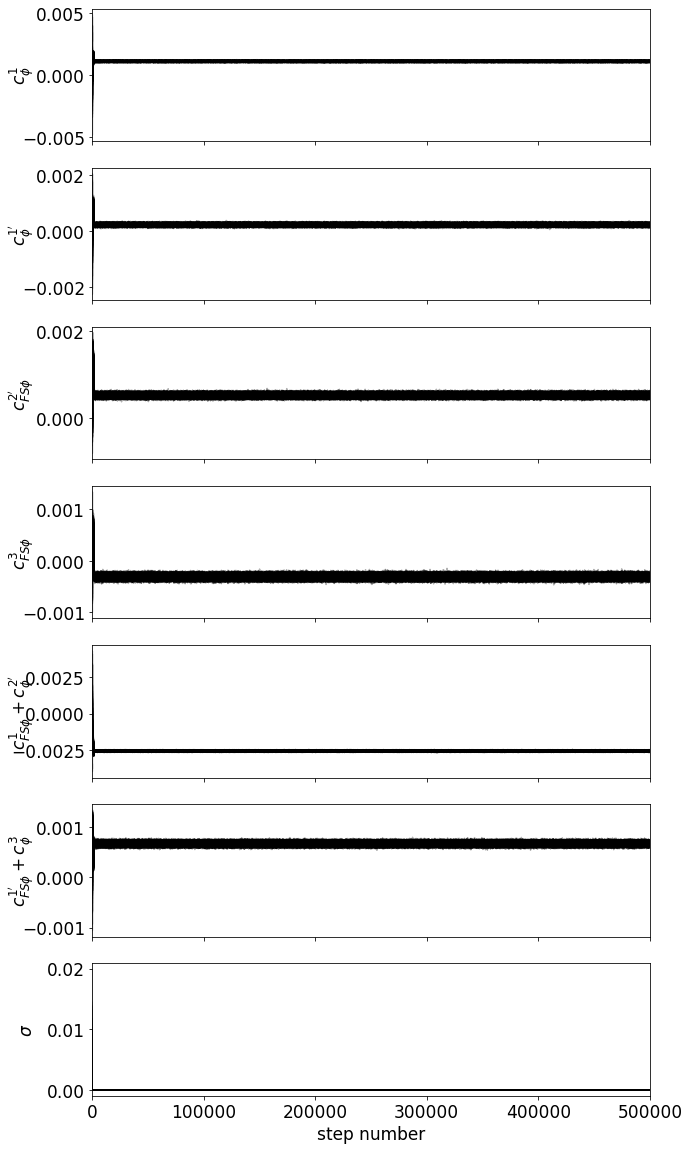

In [106]:
## Plot chains, find autocorrelation 

# Saving
file_name = 'passive-DWS_white-noise'

fig, axes = plt.subplots(7, figsize=(10, 20), sharex=True)
samples = sampler.get_chain()
labels = [r"$c_{\phi}^1$", r"$c_{\phi}^{1^{\prime}}$", r"$c_{FS\phi}^{2^{\prime}}$", r"$c_{FS\phi}^3$", r'$c_{FS\phi}^{1} + c_{\phi}^{2^{\prime}}$', r'$c_{FS\phi}^{1^{\prime}} + c_{\phi}^{3}$', r"$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time()
print(tau)

# Saving chains when they're long enough
try:
    # Autocorrelation - find approx burn time
    tau = sampler.get_autocorr_time()
    print(tau)
    plt.savefig(('chains/TDI-X_chain_num_iter-%g_tau-%g_' + file_name + '.png') %(num_iter, tau[1]))

except:
    #tau = sampler.get_autocorr_time()
    #print(tau)
    print('...Warning...')
    
plt.savefig(('chains/TDI-X_chain_num_iter-%g_dur-%g-s' + file_name + '.png') %(num_iter, dur))

In [110]:
num_burned   = 10000
flat_samples = sampler.get_chain(discard=num_burned, thin=15, flat=True)

'''
corner.corner(
    flat_samples, labels=labels,
    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10}, use_math_text=False, title_fmt='.2E'
)

# Saving samples and figures when the chains are long enough
try:
    tau = sampler.get_autocorr_time()
    print(tau)
    np.savetxt(('samples/TDI-X_samples_num_iter-%g_num_burned-%g_tau-%g_,' + file_name + '.txt') %(num_iter, num_burned, tau[1], tmax, N, k1_RX_true, k1_TX_true, k1p_RX_true, k1p_TX_true), flat_samples)
    plt.savefig(('corner_plots/TDI-X_corner-plot_num_iter-%g_num_burned-%g_tau-%g_' + file_name + '.png') %(num_iter, num_burned, tau[1], tmax, N, k1_RX_true, k1_TX_true, k1p_RX_true, k1p_TX_true))
except:
    print('...Warning: chain not long enough, samples not saved...')
'''

'\ncorner.corner(\n    flat_samples, labels=labels,\n    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10}, use_math_text=False, title_fmt=\'.2E\'\n)\n\n# Saving samples and figures when the chains are long enough\ntry:\n    tau = sampler.get_autocorr_time()\n    print(tau)\n    np.savetxt((\'samples/TDI-X_samples_num_iter-%g_num_burned-%g_tau-%g_,\' + file_name + \'.txt\') %(num_iter, num_burned, tau[1], tmax, N, k1_RX_true, k1_TX_true, k1p_RX_true, k1p_TX_true), flat_samples)\n    plt.savefig((\'corner_plots/TDI-X_corner-plot_num_iter-%g_num_burned-%g_tau-%g_\' + file_name + \'.png\') %(num_iter, num_burned, tau[1], tmax, N, k1_RX_true, k1_TX_true, k1p_RX_true, k1p_TX_true))\nexcept:\n    print(\'...Warning: chain not long enough, samples not saved...\')\n'

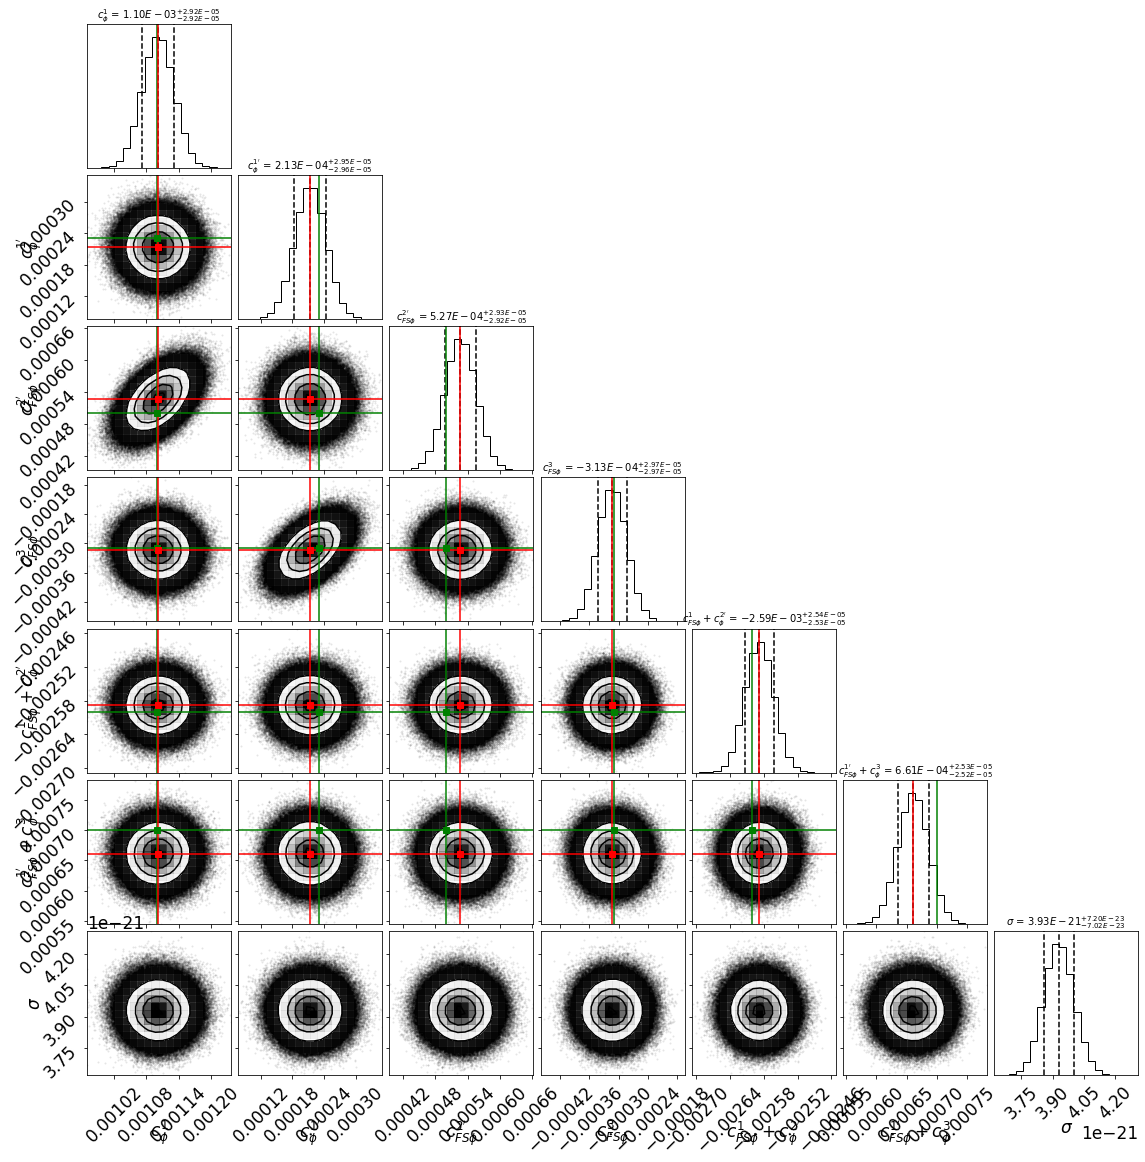

In [112]:
# This is the true mean of the second mode that we used above:
value1 = c_inj

# This is the empirical mean of the sample:
value2 = np.mean(flat_samples, axis=0)

# Make the base corner plot
figure = corner.corner(
    flat_samples, labels=labels,
    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10}, use_math_text=False, title_fmt='.2E'
)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim-1):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")
    ax.axvline(value2[i], color="r")
    
# Loop over the histograms
for yi in range(ndim-1):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axvline(value2[xi], color="r")
        ax.axhline(value1[yi], color="g")
        ax.axhline(value2[yi], color="r")
        ax.plot(value1[xi], value1[yi], "sg")
        ax.plot(value2[xi], value2[yi], "sr")
        
#np.savetxt(('samples/TDI-X_samples_num_iter-%g_num_burned-%g_dur-%g-s_' + file_name + '.txt') %(num_iter, num_burned, dur),flat_samples)
#plt.savefig(('corner_plots/TDI-X_corner-plot_num_iter-%g_num_burned-%g_dur-%g-s_' + file_name + '.png') %(num_iter, num_burned, dur))

In [114]:
from IPython.display import display, Math

for i in range(ndim-1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3E}_{{-{1:.3E}}}^{{{2:.3E}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print('Injected values = ', c_inj)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Injected values =  [0.0011, 0.00023, 0.0005, -0.00031, -0.0026, 0.0007]
